In [1]:
import numpy as np
from disentanglement_error.disentangling_model import DisentanglingModel
from disentanglement_error.error_metric import calculate_disentanglement_error
from sklearn.metrics import accuracy_score
from keras import Sequential
from keras.datasets import cifar10
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping
from keras_uncertainty.models import StochasticClassifier
from keras_uncertainty.layers import StochasticDropout

def entropy(probs, axis=-1, eps=1e-6):
    return -np.sum(probs * np.log(probs + eps), axis=axis)


def predictive_entropy(probs, axis=-1) -> np.ndarray:
    probs = np.mean(probs, axis=0)
    return entropy(probs, axis)


def expected_entropy(probs, eps=1e-6) -> np.ndarray:
    return -np.mean((probs * np.log(probs + eps)).sum(axis=-1), axis=0)


def mutual_information(probs) -> np.ndarray:
    return predictive_entropy(probs) - expected_entropy(probs)


class InformationTheoreticModel(DisentanglingModel):

    def __init__(self):
        super().__init__()

    def fit(self, x, y):
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
        model.add(MaxPooling2D((2, 2)))

        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(Flatten())

        model.add(Dense(64, activation='relu'))
        model.add(StochasticDropout(0.2))
        model.add(Dense(10, activation='softmax'))

        model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        model.fit(x, y, epochs=50, batch_size=32, callbacks=EarlyStopping(monitor='loss', patience=2), verbose=0)
        self.model = StochasticClassifier(model)
        print("Train complete!")


    def predict_disentangling(self, x):
        stochastic_preds = self.model.predict_samples(x, num_samples=25, batch_size=32)

        classifications = stochastic_preds.mean(axis=0).argmax(axis=1)
        aleatorics = expected_entropy(stochastic_preds)
        epistemics = mutual_information(stochastic_preds)
        print("Test complete!")
        return classifications, aleatorics, epistemics


    def score(self, y_true, y_pred):
        return accuracy_score(y_true, y_pred)

    def is_regression(self):
        return False

Keras Uncertainty will use standalone Keras backend

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

kw_config = {"n_runs": 1,
             "dataset_sizes": [0.1, 0.5, 0.9],
             "label_noises": [0.1, 0.5, 0.9],
             }


de, result_json, config_json = calculate_disentanglement_error(x_train, y_train, InformationTheoreticModel(), x_test, y_test, kw_config=kw_config)
print(de)

Train complete!
Test complete!
Train complete!
Test complete!
Train complete!
Test complete!
Train complete!
Test complete!
Train complete!
Test complete!
Train complete!
Test complete!
1.4342454362644363


Experiment
Decreasing Dataset    Axes(0.125,0.11;0.775x0.77)
Label Noise           Axes(0.125,0.11;0.775x0.77)
dtype: object

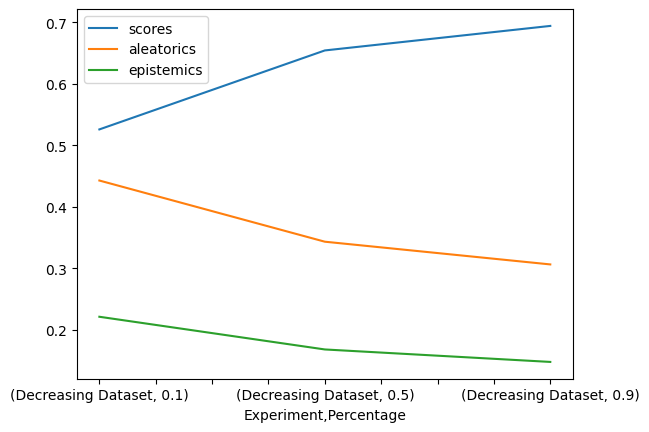

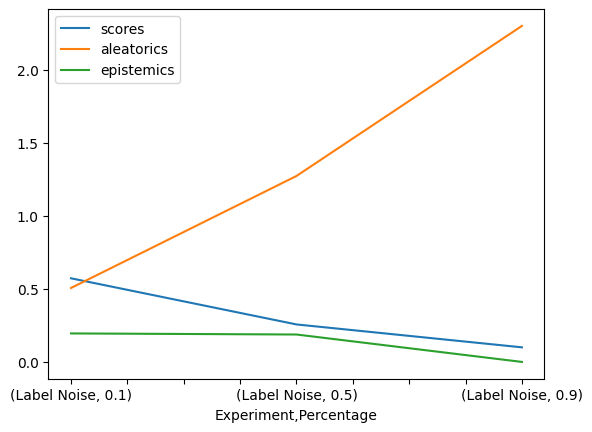

In [3]:
from disentanglement_error.util import json_results_to_df
df = json_results_to_df(result_json, config_json)
df.drop("Run_Index", axis=1).groupby(["Experiment", "Percentage"]).mean().groupby(['Experiment']).plot()